# **Advanced Micro Econometrics - Computer Assignment**
*Author:* [Mathijs de Jong](mailto:m.de.jong@tinbergen.nl)

*Date:* 27 November 2020

We start by initializing the Python environment as follows. Note that the random seed is fixed so that results can be reproduced.

In [1]:
'''
Initialize environment
'''

# Install or upgrade Python dependencies
!pip install -q -U numpy matplotlib pandas scipy statsmodels

# Load Python dependencies
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import scipy
import scipy.io as sio
import statsmodels.api as sm

# Fix random seed
np.random.seed(42)

#### **Exercise 1**
Size distortions: To illustrate the size distortions of the 2SLS $t$-statistic, we simulate data from the following model:
$$\mathbf{Y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}$$
$$\mathbf{X} = \mathbf{Z}\boldsymbol{\Pi} + \mathbf{V}$$
where $\mathbf{Y}$ and $\mathbf{X}$ are $n \times 1$ vectors which contain the endogenous variables and $\mathbf{Z}$ is a $n \times k$ matrix of instruments. $\boldsymbol{\varepsilon}$ and $\mathbf{V}$ are $n \times 1$ vectors that contain the disturbances. The different rows of $(\boldsymbol{\varepsilon} \vdots \mathbf{V})$, $\begin{pmatrix}\boldsymbol{\varepsilon}_{i} \\ \mathbf{V}_{i}\end{pmatrix}^{'}$, $i \in \{1, 2, \ldots, n\}$, are independently normal distributed: $$\begin{pmatrix}\boldsymbol{\varepsilon}_{i} \\ \mathbf{V}_{i}\end{pmatrix} \sim \mathcal{N}(0, \boldsymbol{\Sigma}), \quad \boldsymbol{\Sigma} = \begin{pmatrix}1 \vdots \rho \\ \rho \vdots 1\end{pmatrix}.$$
We use $n = 100$, $k = 10$, $\boldsymbol{\Pi} = a \times \mathbf{e}_{10}$ with $\mathbf{e}_{10}$ a $10 \times 1$ vector whose top element is one and all remaining elements are equal to zero. All elements of $\mathbf{Z}$ are independently standard normal distributed. We only simulate them once and keep them fixed throughout the simulation experiment.

We use five values of $a \in \{0.3, 0.25, 0.2, 0.15, 0.1\}$ and ten different values of $\rho \in \{0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95\}$.

For each value of $a$ make a figure of the rejection frequency as a function of $\rho$ when testing $\text{H}_{0} : \beta = 0$ with 95\% significance using the 2SLS $t$-statistic. Use 5000 simulations from the above model.

What do you conclude?

##### _**Solution:**_
We start by initializing the given parameters for the assignment in the code block below.

In [2]:
'''
Initialize experiment settings
'''

# Specify simulation and data sizes
num_sims = 5000
n = 100
k = 10

# Specify hyperparameter grid
rho_vec = np.append(np.arange(0, 1, 0.1), 0.95)
a_vec = np.arange(0.3, 0.05, -0.05)

# Sample data
beta = 0
Z = np.random.normal(size = (n, k))

The hat matrix and the residual maker matrix of $\mathbf{Z}$ are used in several calculations throughout this assignment. For efficiency, we store the matrices and use the variables throughout the calculations.

In [3]:
'''
Define constants
'''

# Hat matrix of Z
P_Z = Z @ np.linalg.inv(Z.T @ Z) @ Z.T

# Residual maker matrix of Z
M_Z = np.eye(n) - P_Z

Before we continue, we first compute the critical values for the LR statistics for questions 2, 3 and 4. The function in the code block below derives the critical values and uses the pseudo code given in the lecture slides.

In [ ]:
'''

'''
num_steps = 1000
r_beta0 = np.linspace(0, 200, num_steps)

def compute_LR_crit(k, beta_min=0, beta_max=200, num_sims=1e4, num_steps=1e3,
  plot=True, fig_name=None):
  Psi_1 = scipy.stats.chi2.rvs(1, size = (num_sims, 1))
  Psi_k_minus_1 = scipy.stats.chi2.rvs(k - 1, size = (num_sims, 1))
  LR_matrix = np.sort((Psi_k_minus_1 + Psi_1 - r_beta0 \
    + np.sqrt(np.power(Psi_k_minus_1 + Psi_1 + r_beta0, 2) \
    - 4 * np.multiply(r_beta0, Psi_k_minus_1))) / 2, axis = 0)
  LR_crit = LR_matrix[int(0.95 * num_sims), :].reshape((num_steps, ))

  if plot:
    fig = plt.figure(figsize=(8, 6))
    plt.plot(r_beta0, LR_crit)
    plt.xlabel(r'$r(\beta_{0})$')
    plt.ylabel('95\% critical value')
    if fig_name != None:
        plt.savefig(fig_name)
    plt.show()

  return LR_crit

Now that we prepared everything, we can run the simulations. The code block below runs the simulations for all of the different models we are considering.

In [ ]:
results = {test : np.zeros(shape=(len(a_vec), len(rho_vec))) \
  for test in ['t-test', 'AR test', 'LM test', 'LR test']}
LR_crit = compute_LR_crit(k, plot = False)

for i, a in enumerate(a_vec):
  Pi = np.append(a, np.zeros((k - 1, 1))).reshape((k, 1))
  for j, rho in enumerate(len(rho_vec)):
    sigma = np.array([[1, rho], [rho, 1]])
    for s in range(num_sims):

      # Generate simulation data
      eps, V = np.random.multivariate_normal([0, 0], sigma, n).T
      X = Z @ Pi + V.reshape((n, 1))
      y = X * beta + eps.reshape((n, 1))

      # Standard t-test
      beta_2sls = (np.linalg.inv(X.T @ P_Z @ X) @ X.T @ P_Z @ y).item()
      var_beta_2sls = ((y - X * beta_2sls).T @ (y - X * beta_2sls) \
        / (X.T @ P_Z @ X) / (n - 1)).item()
      t_stat = beta_2sls / np.sqrt(var_beta_2sls)
      p_val = 2 * (1 - scipy.stats.t.cdf(np.absolute(t_stat), n - 1))
      if p_val < 0.05: results['t-test'][i, rho_ind] += 1 / num_sims

      # Anderson-Rubinson test
      sigma_eps_eps = y.T @ M_Z @ y / (n - k)
      AR = ((y.T @ P_Z @ y / k) / sigma_eps_eps).item()
      p_val = 1 - scipy.stats.chi2.cdf(k * AR, k)
      if p_val < 0.05: results['AR test'][i, rho_ind] += 1 / num_sims

      # Score test
      sigma_eps_v = (y.T @ M_Z @ X) / (n - k)
      rho_hat = sigma_eps_v / sigma_eps_eps
      Z_Pi_tilde = P_Z @ (X - y @ rho_hat)
      P_Z_Pi_tilde = Z_Pi_tilde @ np.linalg.inv(Z_Pi_tilde.T @ Z_Pi_tilde) \
        @ Z_Pi_tilde.T
      LM = (y.T @ P_Z_Pi_tilde @ y / sigma_eps_eps).item()
      p_val = 1 - scipy.stats.chi2.cdf(LM, 1)
      if p_val < 0.05: results['LM test'][i, rho_ind] += 1 / num_sims

      # LR test
      sigma_v_v = X.T @ M_Z @ X / (n - k)
      sigma_v_v_eps = sigma_v_v - np.power(sigma_eps_v, 2) / sigma_eps_eps
      r_0 = Z_Pi_tilde.T @ Z_Pi_tilde / sigma_v_v_eps 
      LR = (k * AR - r_0 + np.sqrt(np.power(k * AR + r_0, 2) \
        - 4 * r_0 * (k * AR - LM))) / 2
      idx = np.argmin(np.absolute(r_0 - r_beta0))
      if LR > LR_crit[idx]: results['LR test'][i, rho_ind] += 1 / num_sims

a = 0.30
a = 0.25
a = 0.20
a = 0.15
a = 0.10


In the code block below, we define a function that can be used to generate graphs summarizing the results of the $t$-test.

In [ ]:
def print_performance_figures(methods, y_max = 1, fig_name = None):
    fig = plt.figure(figsize=(12, 9))
    gs = gridspec.GridSpec(2, 6)

    for a_ind in range(len(a_vec)):
        row = a_ind // 3
        col = a_ind % 3 * 2 + row

        ax = plt.subplot(gs[row, col:(col + 2)])
        for method in methods:
            ax.plot(rho_vec, results[method][a_ind, :], label = method)
        ax.plot(rho_vec, [0.05 for i in range(len(rho_vec))], ls = "--")
        ax.set_title(r'$a = {:.2f}$'.format(a_vec[a_ind]))
        ax.set_xlim([0, 1])
        ax.set_ylim([0, y_max])
        plt.legend()
        ax.set_xlabel(r'$\rho$')


    plt.tight_layout()
    
    if fig_name != None:
        plt.savefig(fig_name)
    
    plt.show()

We continue with generating the results and save in the file `Ex1_Gr1.png`.

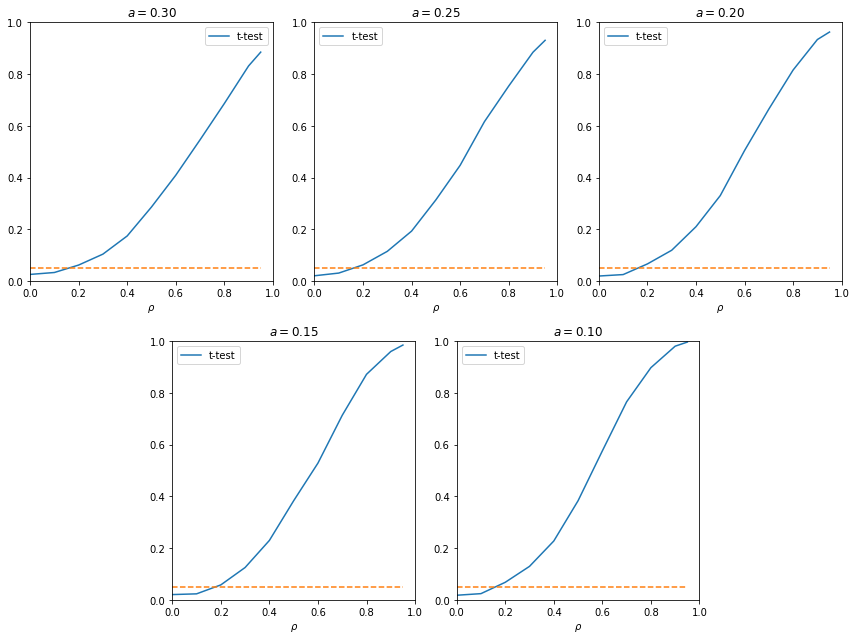

In [ ]:
print_performance_figures(methods = ['t-test'], fig_name = 'Ex1_Gr1.png')

The figure above shows the results from the simulation study. For each value of $a$, the rejection frequency is shown as a function of $\rho$ when testing $\text{H}_{0} : \beta = 0$ with $95\%$ significance using the 2SLS $t$-statistic. The rejection frequency increases in the correlation $\rho$, that is the endogeneity of X, for all values of $a$. Hence, the 2SLS $t$-statistic becomes more size distorted when the endogeneity increases.

When comparing the graphs for the different values of $a$, we find that the rejection frequency given $\rho$ becomes larger for smaller values $a$. Hence, the weaker the instruments, the more size distorted the 2SLS $t$-statistic becomes.

We conclude that strong endogeneity and weak instruments both lead to consistent size distortions of the 2SLS $t$-statistics making it unviable in such cases.

#### Exercise 2
Compute and make a figure of the 95% critical value function of the LR statistic as a function of $r(\beta_{0})$ for $k=10$. What can you say about the critical value when $r(\beta_{0})=0$ or infinite?

##### Solution:
Using the function we defined before, the figure is generated using the code block below and stored as `Ex2_Gr1.png`.

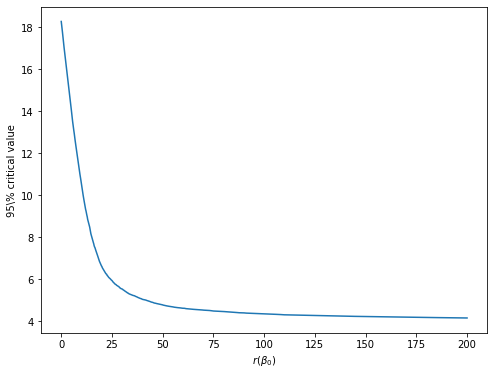

In [ ]:
compute_LR_crit(k = 10, fig_name = 'Ex2_Gr1.png');

The simulated 95\% critical value function of the LR statistic as a function of $r(\beta_{0})$ for $k = 10$ is shown in the figure above. When $r(\beta_{0}) = 0$, the 95\% critical value of the LR statistic equals the critical value of the $\chi^{2}(k)$ distribution, that is, $18.307$ for $k = 10$. In this case the LR statistic is equal to $k$ times the Anderson-Rubin statistic.

When $r(\beta_{0}) \to \infty$, the 95\% critical value converges to $3.841$, that is, the 95\% critical value of the $\chi^{2}(1)$ distribution. In such cases, the LR statistic converges to the score statistic.

#### Exercise 3
Repeat the excercise in 1 for the AR, score and LR statistics. What do you conclude?

##### Solution:
The code block below uses the function defined before to generate the graphs and saves the output to the file `Ex3_Gr1.png`.

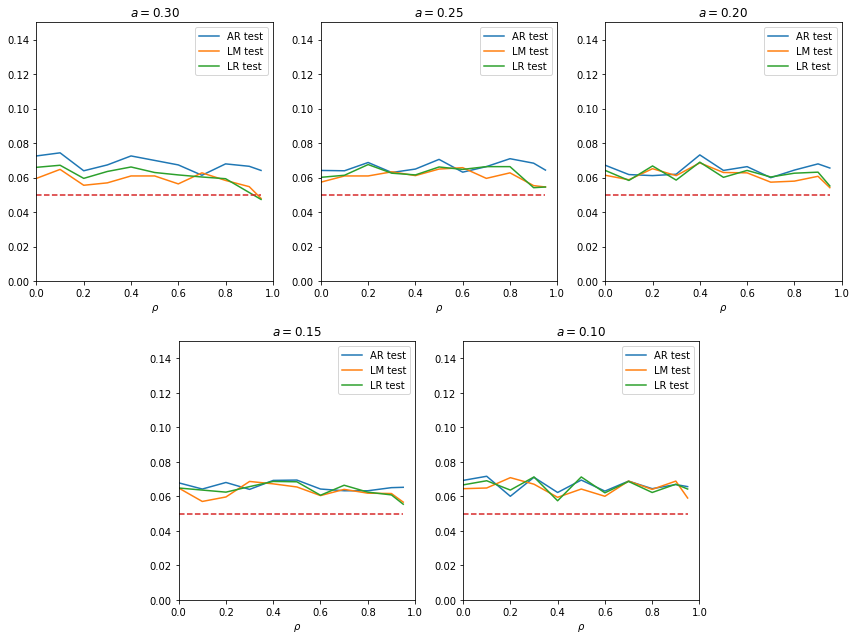

In [ ]:
print_performance_figures(
    methods = ['AR test', 'LM test', 'LR test'],
    y_max = 0.15,
    fig_name = 'Ex3_Gr1.png'
)

The Figure above shows the results from the simulation study for the AR, score and LR statistics. For each value of $a$, the rejection frequency is shown as a function of $\rho$ when testing $\text{H}_{0} : \beta = 0$ with $95\%$ significance using the AR, score and LR statistics. We find that for all values of $a$ and $\rho$, the tests are stable. The rejection frequencies are approximately $0.065$ which is above the desired $5\%$ significance level. The score statistic has the lowest rejection frequency and the AR statistic has the largest rejection frequency.

The problems that occurred for strong endogeneity and weak instruments when using the 2SLS $t$-statistics are no longer present, and hence we conclude that the test AR, score and LR test statistics are robust to strong endogeneity and weak instruments making them generally applicable.

#### Exercise 4
Compute and make a figure of the 95% critical value function of the LR statistic as a function of $r(\beta_{0})$ for $k=4$.

##### Solution:
Similar to question 2, we use the function defined above and save the graph as `Ex4_Gr1.png`.

In [ ]:
compute_LR_crit(k = 4, fig_name = 'Ex4_Gr1.png');

See the answer of Exercise 2.

#### Exercise 5
[Card (1993)](https://www.nber.org/papers/w4483) analyzes the return on education. He uses different proximity to college variables as instruments. The file `assigmentweakinstruments.mat` contains that part of the Card data which we use for this assignment. The di§erent variables in the file are: `nearc2`: if near a 2 year college, `nearc4`: if near a 4 year college, `nearc4a`: if near a 4 year community college, `nearc4b`: if near a 4 year private college, `ed`: years of education, `wage`: log-earnings, `age`: age in years, `age2`: squared age, `exper`: experience, `exper2`: experience squared, `south`: lives in the South, `smsa`: lives in a metropolitan area, `race`: racial indicator.

The variables `wage` and `ed` constitute the endogenous variables ($\mathbf{Y}$ and $\mathbf{X}$), `nearc2`, `nearc4`, `nearc4a`, `nearc4b` are instruments ($\mathbf{Z}$) and `exper`, `exper2`, `south`, `smsa`, `race` and the constant term are the included exogenous variables ($w$). Note that we do not use `age` and `age2`.


Before we continue, we first load the data. Note that the file was shared publicly on my Google Drive account and that we need to remove some meta information of the .mat file to be able to cast the data into a DataFrame.

In [ ]:
!wget https://docs.google.com/uc?id=1NXXUZiKhYFufpLFXznnAWQIUAyxP3R1S
!mv uc?id=1NXXUZiKhYFufpLFXznnAWQIUAyxP3R1S 'assignmentweakinstruments.mat'
data = sio.loadmat('/content/assignmentweakinstruments.mat')
del data['__globals__']; del data['__header__']; del data['__version__']
for key in data.keys(): data[key] = data[key].reshape(data[key].shape[0],)
df = pd.DataFrame(data)

df.head()

--2019-12-03 08:54:24--  https://docs.google.com/uc?id=1NXXUZiKhYFufpLFXznnAWQIUAyxP3R1S
Resolving docs.google.com (docs.google.com)... 64.233.189.100, 64.233.189.138, 64.233.189.139, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qsgqkokc51dg48a39acr4smpeltbergl/1575360000000/07337861175812329451/*/1NXXUZiKhYFufpLFXznnAWQIUAyxP3R1S [following]
--2019-12-03 08:54:24--  https://doc-04-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qsgqkokc51dg48a39acr4smpeltbergl/1575360000000/07337861175812329451/*/1NXXUZiKhYFufpLFXznnAWQIUAyxP3R1S
Resolving doc-04-64-docs.googleusercontent.com (doc-04-64-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-04-64-docs.googleusercontent.com (doc-04-64-docs.googleusercontent.com)|74.125.204.

,age2,exper2,wage,ed,age,smsa,south,exper,race,nearc2,nearc4,nearc4a,nearc4b
0,841,256,6.306275,7,29,1,0,16,1,0,0,0,0.001220
1,729,81,6.175867,12,27,1,0,9,0,0,0,0,-0.002496
2,1156,256,6.580639,12,34,1,0,16,0,0,0,0,-0.000917
3,729,100,5.521461,11,27,1,0,10,0,1,1,1,-0.001483
4,1156,256,6.591674,12,34,1,0,16,0,1,1,1,0.000939


Now that we have the data, we can continue extracting the relevant information.

In [ ]:
n = df.shape[0]

# Variables
Y_star = df[['wage']]
X_star = df[['ed']]
Z_star = df[['nearc2', 'nearc4', 'nearc4a', 'nearc4b']]
W_df = df[['exper', 'exper2', 'south', 'smsa', 'race']]
W_df['const'] = np.ones((n, 1))
W = W_df.values
M_W = np.eye(n) - W @ np.linalg.inv(W.T @ W) @ W.T

# Transformed variables (without exogeneous variables)
Y = M_W @ Y_star.values
X = M_W @ X_star.values
Z = M_W @ Z_star.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**5.a)** Using only `near2c` as an instrument, construct the 95% confidence set for the return on education using the 2SLS t-statistic and the AR statistic.

##### Solution:
Run the code block below to construct the 95% confidence set for the 2SLS $t$-statistic.

In [ ]:
# Estimate model with 2SLS and construct the confidence set
Z_nearc2 = Z[:, 0].reshape((n, 1))
P_Z_nearc2 = Z_nearc2 @ np.linalg.inv(Z_nearc2.T @ Z_nearc2) @ Z_nearc2.T
beta_2sls = (np.linalg.inv(X.T @ P_Z_nearc2 @ X) @ X.T @ P_Z_nearc2 @ Y).item()
var_beta_2sls = ((Y - X * beta_2sls).T @ (Y - X * beta_2sls) / (X.T @ P_Z_nearc2 @ X) / (n - 1)).item()
t_stat = beta_2sls / np.sqrt(var_beta_2sls)
p_val = 2 * (1 - scipy.stats.t.cdf(np.absolute(t_stat), n - 1))
con_set_t_nearc2 = [beta_2sls - np.sqrt(var_beta_2sls) * scipy.stats.t.ppf(1 - 0.025, n - 1), beta_2sls \
                    + np.sqrt(var_beta_2sls) * scipy.stats.t.ppf(1 - 0.025, n - 1)]
print(con_set_t_nearc2)

[-0.04348185177658498, 0.7430090199491068]


Run the code block below for similar results for the AR statistic and a visualization of the confidence set.

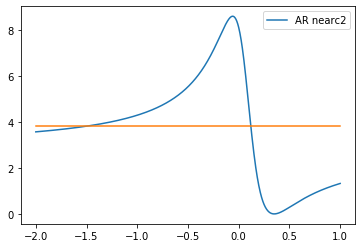

[(-inf, -1.4744744744744744), (0.11711711711711725, inf)]


In [ ]:
# Construct AR confidence set
beta0 = np.linspace(-2, 1, 1000)
p_val_AR_nearc2 = np.full((len(beta0),1), np.nan)
kAR_stat_nearc2 = np.full((len(beta0),1), np.nan)

M_Z_nearc2 = np.eye(n) - P_Z_nearc2
for i in range(len(beta0)):
    sigma_eps_eps = (Y - X * beta0[i]).T @ M_Z_nearc2 @ (Y - X * beta0[i]) / (n - 1)
    kAR_stat_nearc2[i] = (Y - X * beta0[i]).T @ P_Z_nearc2 @ (Y - X * beta0[i]) / sigma_eps_eps

plt.plot(beta0, kAR_stat_nearc2, label = 'AR nearc2')
plt.plot(beta0, np.ones((len(beta0), )) * scipy.stats.chi2.ppf(0.95, 1))
plt.legend()
plt.savefig('Ex5_Gr1.png')
plt.show()

beta0 = [beta0[i] if kAR_stat_nearc2[i] > scipy.stats.chi2.ppf(0.95, 1) else np.mean(beta0) for i in range(len(beta0))]
con_set_AR_nearc2 = [(-np.inf , np.min(beta0)), (np.max(beta0), np.inf)]
print(con_set_AR_nearc2)

The 95% confidence set for the return on education based on the 2SLS $t$-statistic is given by $(-0.043, 0.743)$. The 95\% confidence set for the return on education based on the the AR statistic is given by $(-\infty, 1.474) \cup (0.117, \infty)$.

**5.b)** Is there a difference between these confidence sets and if so can you explain why this difference occurs?

##### Solution:
The confidence sets of the 2SLS $t$-statistic and the AR statistic differ considerable. The confidence set of the 2SLS $t$-statistic is bounded while the confidence set of the AR statistic consists of two disjoint sets and is unbounded towards both positive and negative numbers which indicates weak instruments. As we saw in question 1, the 2SLS $t$-statistic is not robust in this case.

**5.c)** What is the value of the first stage $F$-statistic and what does the value of the AR statistic look like when the tested parameter is large.

##### Solution:
The code block below can be used to compute the first-step F-statistic.

In [ ]:
# Compute the first-stage F-statistic
sigma_vv = X.T @ M_Z_nearc2 @ X / (n - 1)
F = (X.T @ P_Z_nearc2.T @ P_Z_nearc2 @ X) / sigma_vv
print(F.item())

2.810463577873667


The first-stage $F$-statistic is equal to 2.810. For 2SLS $t$-statistics to be reliable, the rule of thumb is to require a first-stage $F$-statistic of at least ten. The AR($\beta_{0}$) statistic that tests for an infinite value of $\beta_{0}$ is equal to the first-stage $F$-statistic for the test $\Pi = \vec{0}$. Therefore, when the tested parameter is large, the AR($\beta_{0}$) statistic converges to the first-stage $F$-statistic.

**5.d)** We did not use the LM and LR statistics in a or did we?

##### Solution:
Since the AR, score and LR statistics are equivalent when there is only one instrument, that is, when $k = 1$, we used all three statistics in question 5a.

**5.e)** Using `nearc4`, `nearc2`, `nearc4a` and `nearc4b` as instruments, construct the 95% confidence set for the return on education using the 2SLS $t$-statistic, AR, LM and LR statistics.

##### Solution:
The code blocks below can be ran to find the confidence sets.

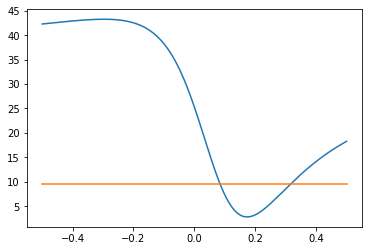

[0.0855855855855856, 0.31481481481481477]


In [ ]:
LB = -0.5
UB = 0.5
M = 1000
beta0 = np.linspace(LB, UB, M)

# % Estimate model with 2SLS
P_Z = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
beta_2sls = (np.linalg.inv(X.T @ P_Z @ X) @ (X.T @ P_Z @ Y))
var_beta_2sls = (Y - X @ beta_2sls).T @ (Y - X @ beta_2sls) / (X.T @ P_Z @ X) / (n - 4)

# Construct t confidence set
t_stat = beta_2sls/np.sqrt(var_beta_2sls)
con_set_t = [beta_2sls - np.sqrt(var_beta_2sls) * scipy.stats.t.ppf(1 - 0.025, n - 4), beta_2sls + np.sqrt(var_beta_2sls) * scipy.stats.t.ppf(1 - 0.025, n - 4)]
         
# Construct AR confidence set
kAR_stat = np.full((len(beta0),1), np.nan)
M_Z = np.eye(n) - P_Z

for i in range(len(beta0)):
  sigma_eps_eps = ((Y - X * beta0[i]).T @ M_Z @ (Y - X * beta0[i])) / (n - 4)
  kAR_stat[i] = ((Y - X * beta0[i]).T @ P_Z @ (Y - X * beta0[i])) / sigma_eps_eps

plt.plot(beta0, kAR_stat)
plt.plot(beta0, np.ones((len(beta0),)) * scipy.stats.chi2.ppf(0.95, 4))
plt.savefig('Ex5_Gr2.png')
plt.show()

for i in range(len(beta0)):
  if kAR_stat[i] < scipy.stats.chi2.ppf(0.95, 4):
    beta0_min = beta0[i]
    break

for i in np.arange(len(beta0) - 1, 0, -1):
  if kAR_stat[i] < scipy.stats.chi2.ppf(0.95, 4):
    beta0_max = beta0[i]
    break

con_set_AR = [beta0_min, beta0_max]
print(con_set_AR)

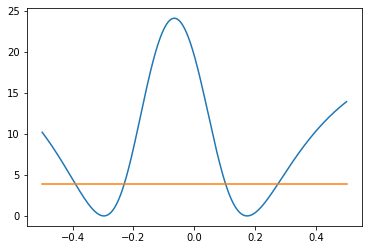

[(-0.3898898898898899, -0.23073073073073075), (0.10360360360360354, 0.27377377377377377)]


In [ ]:
# Construct LM confidence set 
LM_stat = np.full((len(beta0),1), np.nan)
for i in range(len(beta0)):
    sigma_eps_eps = ((Y - X * beta0[i]).T @ M_Z @ (Y - X * beta0[i])) / (n - 4)
    sigma_eps_v = ((Y - X * beta0[i]).T @ M_Z @ X) / (n - 4)
    rho_hat = sigma_eps_v / sigma_eps_eps
    Z_Pi_tilde = P_Z @ (X - (Y - X * beta0[i]) * rho_hat)
    P_Z_Pi_tilde = Z_Pi_tilde @ np.linalg.inv(Z_Pi_tilde.T @ Z_Pi_tilde) @ Z_Pi_tilde.T
    LM_stat[i] = (Y - X * beta0[i]).T @ P_Z_Pi_tilde @ (Y - X * beta0[i]) / sigma_eps_eps


plt.plot(beta0, LM_stat)
plt.plot(beta0, np.ones((len(beta0,))) * scipy.stats.chi2.ppf(0.95,1))
plt.savefig('Ex5_Gr3.png')
plt.show()

tmp_1 = np.multiply(beta0.T, np.multiply((LM_stat < scipy.stats.chi2.ppf(0.95,1)), (beta0.T < 0)))
tmp_2 = np.multiply(beta0.T, np.multiply((LM_stat < scipy.stats.chi2.ppf(0.95,1)), (beta0.T >0)))
tmp_1 = tmp_1[np.absolute(tmp_1) != 0]
tmp_2 = tmp_2[np.absolute(tmp_2) != 0]

min_ind = 0
max_ind = 0
beta0_min = [0, 0]
beta0_max = [0, 0]

for i in range(1, len(beta0)):
  if LM_stat[i - 1] > scipy.stats.chi2.ppf(0.95,1) > LM_stat[i]:
    beta0_min[min_ind] = beta0[i]
    min_ind = min_ind + 1
  if LM_stat[i - 1] < scipy.stats.chi2.ppf(0.95,1) < LM_stat[i]:
    beta0_max[max_ind] = beta0[i]
    max_ind = max_ind + 1

con_set_LM = [(beta0_min[0], beta0_max[0]), (beta0_min[1], beta0_max[1])]
print(con_set_LM)

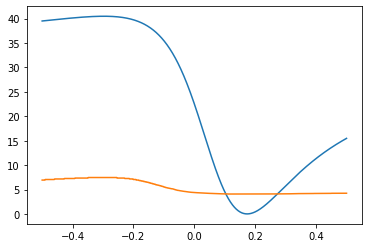

[0.10360360360360354, 0.2727727727727728]


In [ ]:
# Construct LR confidence set 
LR_stat = np.full((len(beta0),1), np.nan)
LR_CV = np.full((len(beta0),1), np.nan)
LR_crit = compute_LR_crit(k = 4, plot=False)

for i in range(len(beta0)):
    sigma_eps_eps = ((Y - X * beta0[i]).T @ M_Z @ (Y - X * beta0[i])) / (n - 4)
    sigma_eps_v = ((Y - X * beta0[i]).T @ M_Z @ X) / (n - 4)
    rho_hat = sigma_eps_v / sigma_eps_eps
    Z_Pi_tilde = P_Z @ (X - (Y - X * beta0[i]) * rho_hat)
    sigma_v_v = X.T @ M_Z @ X / (n - 4)
    sigma_v_v_eps = sigma_v_v - np.power(sigma_eps_v, 2) / sigma_eps_eps
    r_0 = Z_Pi_tilde.T @ Z_Pi_tilde / sigma_v_v_eps          
    LR_stat[i] = (kAR_stat[i] - r_0 + np.sqrt(np.power(kAR_stat[i] + r_0, 2) - 4 * r_0 * (kAR_stat[i] - LM_stat[i]))) / 2
    idx = np.argmin(np.absolute(r_0 - r_beta0))
    LR_CV[i] = LR_crit[idx]

plt.plot(beta0, LR_stat)
plt.plot(beta0, LR_CV)
plt.savefig('Ex5_Gr4.png')
plt.show()

for i in range(len(beta0)):
  if LR_stat[i] < LR_CV[i]:
    beta0_min = beta0[i]
    break

for i in np.arange(len(beta0) - 1, 0, -1):
  if LR_stat[i] < LR_CV[i]:
    beta0_max = beta0[i]
    break

con_set_LR = [beta0_min, beta0_max]
print(con_set_LR)

The results can also be visualized. Run the code block below to see the outcome.

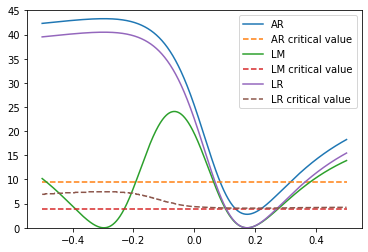

In [ ]:
# figure 
plt.plot(beta0, kAR_stat, label = 'AR')
plt.plot(beta0, np.ones(len(beta0),) * scipy.stats.chi2.ppf(0.95, 4), ls = '--', label = 'AR critical value')
plt.plot(beta0, LM_stat, label = 'LM')
plt.plot(beta0, np.ones(len(beta0),) * scipy.stats.chi2.ppf(0.95, 1), ls = '--', label = 'LM critical value')
plt.plot(beta0, LR_stat, label = 'LR')
plt.plot(beta0, LR_CV, ls = '--', label = 'LR critical value')
plt.legend()
plt.ylim(0, 45)
plt.savefig('Ex5_Gr_5.png')
plt.show()

The $95\%$ confidence sets for the return on education, using `nearc4`, `nearc2`, `nearc4a` and `nearc4b` as instruments are shown in the table below. Note that the interval $(-0.390, -0.232)$ was not included for the score statistic. For a justification, see the answer in 5f.


|     ||2SLS   | AR    | Score | LR    |
|-----||-------|-------|-------|-------|
| LB  || 0.094 | 0.086 | 0.104 | 0.104 |
| UB  || 0.237 | 0.315 | 0.273 | 0.274 |

**5.f)** Is there a difference between these confidence sets and if so can you explain why this difference occurs?

##### Solution:
The confidence sets of the 2SLS $t$-statistic, AR, score and LR statistics show no clear differences besides that the score statistic has the additional confidence region $(-0.390, -0.232)$. The additional interval is a result from using the concentrated likelihood function and can be seen as a weakness of the method. We can ignore this interval for the analysis.
    
The reason that there are no further clear differences is because we have strong instruments which is supported by the first-stage $F$-statistic that is equal to $34.672$.

In [ ]:
sigma_vv = X.T @ M_Z @ X / (n - 1)
F = (X.T @ P_Z.T @ P_Z @ X) / sigma_vv
print(F.item())

34.67227923502968
